# Exploratory Data Analysis

In [1]:
import polars as pl

# define the schema of the dataframe
df_schema = {"timestamp": pl.UInt64, "visitorid": pl.UInt32, "event": pl.Utf8, "itemid": pl.Utf8, "transactionid": pl.UInt32}

events_df = (
    pl.read_csv('../data/events.csv', schema=df_schema, low_memory=True)
    # Convert timestamp to seconds and cast to UInt32 to save memory
    .with_columns((pl.col("timestamp")//1000).cast(pl.UInt32))
)

print(events_df)

shape: (2_756_101, 5)
┌────────────┬───────────┬───────┬────────┬───────────────┐
│ timestamp  ┆ visitorid ┆ event ┆ itemid ┆ transactionid │
│ ---        ┆ ---       ┆ ---   ┆ ---    ┆ ---           │
│ u32        ┆ u32       ┆ str   ┆ str    ┆ u32           │
╞════════════╪═══════════╪═══════╪════════╪═══════════════╡
│ 1433221332 ┆ 257597    ┆ view  ┆ 355908 ┆ null          │
│ 1433224214 ┆ 992329    ┆ view  ┆ 248676 ┆ null          │
│ 1433221999 ┆ 111016    ┆ view  ┆ 318965 ┆ null          │
│ 1433221955 ┆ 483717    ┆ view  ┆ 253185 ┆ null          │
│ 1433221337 ┆ 951259    ┆ view  ┆ 367447 ┆ null          │
│ …          ┆ …         ┆ …     ┆ …      ┆ …             │
│ 1438398785 ┆ 591435    ┆ view  ┆ 261427 ┆ null          │
│ 1438399813 ┆ 762376    ┆ view  ┆ 115946 ┆ null          │
│ 1438397820 ┆ 1251746   ┆ view  ┆ 78144  ┆ null          │
│ 1438398530 ┆ 1184451   ┆ view  ┆ 283392 ┆ null          │
│ 1438400163 ┆ 199536    ┆ view  ┆ 152913 ┆ null          │
└────────────┴────

In [2]:
# Form sessions by splitting the events of a user to sessions based on time between the events
# If the time between events is more than 30 minutes, it is considered a new session

sessions_df = (
    events_df
    .sort(["visitorid", "timestamp"], descending=[False, False])
    .with_columns(
        previous_visitorid = pl.col("visitorid").shift(1),
        previous_timestamp = pl.col("timestamp").shift(1),
    )
    .with_columns(
        time_between_sec = pl.when(pl.col("previous_visitorid") == pl.col("visitorid")).then((pl.col("timestamp") - pl.col("previous_timestamp"))).otherwise(None)
    )
    .with_columns(
        is_session_boundary = (pl.col("time_between_sec").is_null() | (pl.col("time_between_sec") >= 30*60))
    )
    .with_columns(
        session = pl.col("is_session_boundary").cum_sum().cast(pl.UInt32),
    )
    .drop(["previous_visitorid", "previous_timestamp", "time_between_sec", "is_session_boundary"])
    # Count the amount of events in a session
    .with_columns(events_count = (pl.col("timestamp").rle_id().max().over("session") + 1))
    # Filter out sessions with only 1 event
    .filter(pl.col("events_count") > 1)
    .drop("events_count")
)

print(sessions_df)

shape: (1_372_863, 6)
┌────────────┬───────────┬───────┬────────┬───────────────┬─────────┐
│ timestamp  ┆ visitorid ┆ event ┆ itemid ┆ transactionid ┆ session │
│ ---        ┆ ---       ┆ ---   ┆ ---    ┆ ---           ┆ ---     │
│ u32        ┆ u32       ┆ str   ┆ str    ┆ u32           ┆ u32     │
╞════════════╪═══════════╪═══════╪════════╪═══════════════╪═════════╡
│ 1442004589 ┆ 0         ┆ view  ┆ 285930 ┆ null          ┆ 1       │
│ 1442004759 ┆ 0         ┆ view  ┆ 357564 ┆ null          ┆ 1       │
│ 1442004917 ┆ 0         ┆ view  ┆ 67045  ┆ null          ┆ 1       │
│ 1438969904 ┆ 2         ┆ view  ┆ 325215 ┆ null          ┆ 3       │
│ 1438970013 ┆ 2         ┆ view  ┆ 325215 ┆ null          ┆ 3       │
│ …          ┆ …         ┆ …     ┆ …      ┆ …             ┆ …       │
│ 1437973995 ┆ 1407573   ┆ view  ┆ 57720  ┆ null          ┆ 1761681 │
│ 1438402327 ┆ 1407573   ┆ view  ┆ 363109 ┆ null          ┆ 1761682 │
│ 1438402365 ┆ 1407573   ┆ view  ┆ 463766 ┆ null          ┆ 1761682 

### Train test split

Train test split is done by splitting the data based on time. The last two weeks of the data is used as the test set and the 3 weeks before that are used as the training set.

The train and test sets are filtered to only include sessions that have at least one cart or order event. This is done to make the test set more realistic and to make the evaluation more meaningful.
The sessions that appear in the test set are removed from the training set to avoid data leakage.

In [138]:
# Train test split

max_ts = (
    sessions_df
    .select("timestamp")
    .max()
    .item()
)

# 2 weeks
test_start = max_ts - 2*7*24*60*60

# 3 weeks
train_start = test_start - 3*7*24*60*60

# We are only interested in sessions containing cart or order events
sessions_with_cart_or_order = (
    sessions_df
    .filter(pl.col("event") != "view")
    .group_by("session")
    .agg(pl.col("event").unique().alias("unique_events"))
    .sort("session")
    .select("session")
)

# Test dataset is 1 week before the last week
test_df = (
    sessions_df
    .filter(pl.col("timestamp") >= test_start)
    # Count the amount of events in a session
    .with_columns(events_count = (pl.col("timestamp").rle_id().max().over("session") + 1))
    # Filter out sessions with only 1 event
    .filter(pl.col("events_count") > 1)
    .drop("events_count")
    # Filter out sessions with only clicks
    .join(sessions_with_cart_or_order, on="session", how="inner")
)


# Get unique test sessions
test_sessions = test_df.select("session").unique()


# Train dataset is 3 weeks before the last week
train_df = (
    sessions_df
    .filter((pl.col("timestamp") >= train_start) & (pl.col("timestamp") < test_start))
    # Filter out sessions that appear in the test dataset
    .join(test_sessions, on="session", how="anti")
    # Count the amount of events in a session
    .with_columns(events_count = (pl.col("timestamp").rle_id().max().over("session") + 1))
    # Filter out sessions with only 1 event
    .filter(pl.col("events_count") > 1)
    .drop("events_count")
    # Filter out sessions with only clicks
    .join(sessions_with_cart_or_order, on="session", how="inner")
)

n_train_sessions = train_df.select("session").n_unique()
n_test_sessions = test_sessions.n_unique()
print("Number of train sessions:", n_train_sessions)
print("Number of test sessions:", n_test_sessions)
print()

print("Train df")
print(train_df)
print()
print("Test df")
print(test_df)

Number of train sessions: 5967
Number of test sessions: 3625

Train df
shape: (35_579, 6)
┌────────────┬───────────┬───────────┬────────┬───────────────┬─────────┐
│ timestamp  ┆ visitorid ┆ event     ┆ itemid ┆ transactionid ┆ session │
│ ---        ┆ ---       ┆ ---       ┆ ---    ┆ ---           ┆ ---     │
│ u32        ┆ u32       ┆ str       ┆ str    ┆ u32           ┆ u32     │
╞════════════╪═══════════╪═══════════╪════════╪═══════════════╪═════════╡
│ 1439599752 ┆ 172       ┆ view      ┆ 10034  ┆ null          ┆ 237     │
│ 1439599816 ┆ 172       ┆ addtocart ┆ 10034  ┆ null          ┆ 237     │
│ 1439599994 ┆ 172       ┆ view      ┆ 62300  ┆ null          ┆ 237     │
│ 1439600123 ┆ 172       ┆ view      ┆ 202268 ┆ null          ┆ 237     │
│ 1439600616 ┆ 172       ┆ view      ┆ 107943 ┆ null          ┆ 237     │
│ …          ┆ …         ┆ …         ┆ …      ┆ …             ┆ …       │
│ 1440453473 ┆ 1406910   ┆ addtocart ┆ 152134 ┆ null          ┆ 1760851 │
│ 1440453500 ┆ 1406910

### Product category information

In [139]:
# category tree
df_schema = {"categoryid": pl.UInt32, "parentid": pl.UInt32}
category_tree_df = (
    pl.read_csv('../data/category_tree.csv', schema=df_schema, low_memory=True)
)

# item categories
# we keep timestamp since there is possibility that the category changes over time
df_schema = {"timestamp": pl.UInt64, "itemid": pl.UInt32, "property": pl.Utf8, "value": pl.Utf8}
item_categories_df = (
    pl.concat([
        pl.read_csv('../data/item_properties_part1.csv', schema=df_schema, low_memory=True),
        pl.read_csv('../data/item_properties_part2.csv', schema=df_schema, low_memory=True)
    ])
    # Convert timestamp to seconds and cast to UInt32 to save memory
    .with_columns((pl.col("timestamp")//1000).cast(pl.UInt32))
    # Filter all but categoryid
    .filter(pl.col("property") == "categoryid")
    .with_columns(categoryid = pl.col("value").cast(pl.UInt32))
    .drop(["property", "value"])
    # Find the parentid for each categoryid. If parentid is null, use categoryid as parentid
    .join(category_tree_df, on="categoryid", how="left")
    .with_columns(parentid = pl.col("parentid").fill_null(pl.col("categoryid")))
    # Filter by train timestamp
    .filter(pl.col("timestamp") >= train_start, pl.col("timestamp") < test_start)
    .drop("timestamp")
    .unique()
    .sort(["itemid", "categoryid", "parentid"])
)

print(item_categories_df)

shape: (31_407, 3)
┌────────┬────────────┬──────────┐
│ itemid ┆ categoryid ┆ parentid │
│ ---    ┆ ---        ┆ ---      │
│ u32    ┆ u32        ┆ u32      │
╞════════╪════════════╪══════════╡
│ 25     ┆ 72         ┆ 620      │
│ 75     ┆ 1421       ┆ 105      │
│ 94     ┆ 1147       ┆ 1027     │
│ 94     ┆ 1244       ┆ 500      │
│ 100    ┆ 618        ┆ 105      │
│ …      ┆ …          ┆ …        │
│ 466768 ┆ 1147       ┆ 1027     │
│ 466768 ┆ 1244       ┆ 500      │
│ 466783 ┆ 1114       ┆ 113      │
│ 466829 ┆ 438        ┆ 312      │
│ 466829 ┆ 1277       ┆ 312      │
└────────┴────────────┴──────────┘


### Amount of events per session

In [140]:
# amount of events per session
events_count = (
    train_df
    .group_by("session")
    .agg(pl.len().alias("events_count"))
    .sort("events_count")
    .select("events_count")
)

print(events_count)
print(events_count.describe())

shape: (5_967, 1)
┌──────────────┐
│ events_count │
│ ---          │
│ u32          │
╞══════════════╡
│ 2            │
│ 2            │
│ 2            │
│ 2            │
│ 2            │
│ …            │
│ 94           │
│ 101          │
│ 119          │
│ 125          │
│ 129          │
└──────────────┘
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ events_count │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 5967.0       │
│ null_count ┆ 0.0          │
│ mean       ┆ 5.962628     │
│ std        ┆ 8.094301     │
│ min        ┆ 2.0          │
│ 25%        ┆ 2.0          │
│ 50%        ┆ 4.0          │
│ 75%        ┆ 6.0          │
│ max        ┆ 129.0        │
└────────────┴──────────────┘


In [141]:
# Count how many percent are under 100 events
under_100 = events_count.filter(pl.col("events_count") < 100).height
total = events_count.height
print(f"Percentage of sessions with less than 100 events: {under_100 / total * 100:.2f}%")

# Count how many percent are under 10 events
under_10 = events_count.filter(pl.col("events_count") < 10).height
total = events_count.height
print(f"Percentage of sessions with less than 10 events: {under_10 / total * 100:.2f}%")

# Count how many percent are under 5 events
under_5 = events_count.filter(pl.col("events_count") < 5).height
total = events_count.height
print(f"Percentage of sessions with less than 5 events: {under_5 / total * 100:.2f}%")

# Count how many percent are 2 events
exactly_2 = events_count.filter(pl.col("events_count") == 2).height
total = events_count.height
print(f"Percentage of sessions with 2 events: {exactly_2 / total * 100:.2f}%")

Percentage of sessions with less than 100 events: 99.93%
Percentage of sessions with less than 10 events: 86.53%
Percentage of sessions with less than 5 events: 63.40%
Percentage of sessions with 2 events: 26.63%


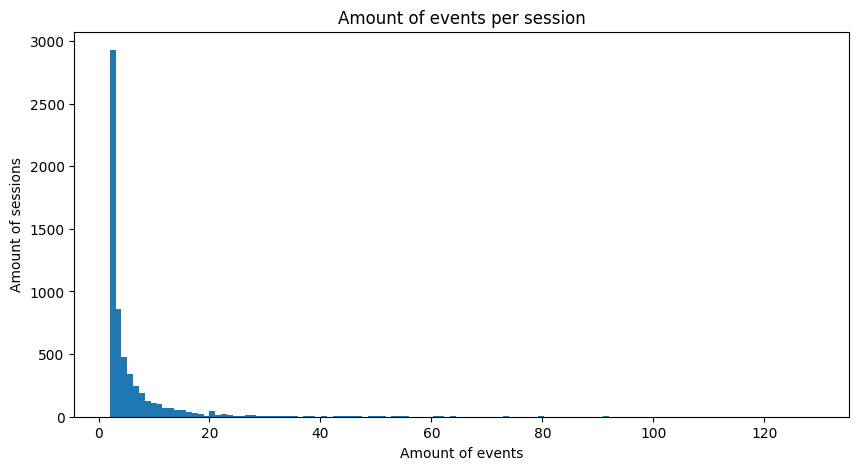

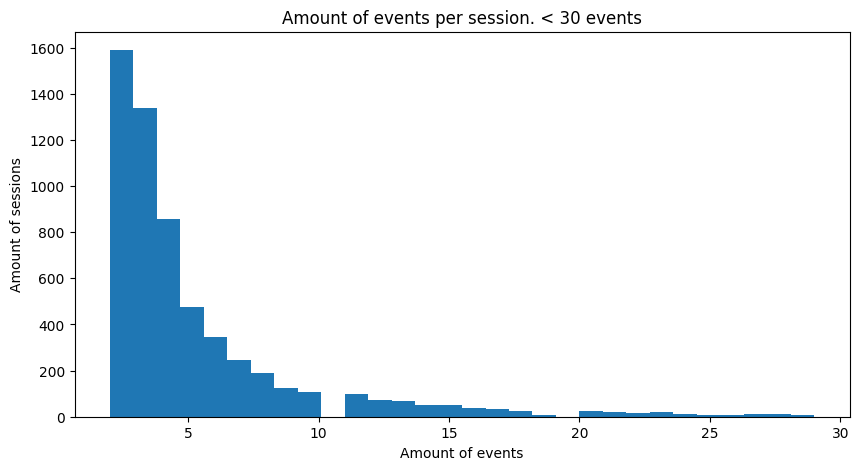

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(events_count.to_numpy(), bins=120)
plt.title("Amount of events per session")
plt.xlabel("Amount of events")
plt.ylabel("Amount of sessions")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(events_count.filter(pl.col("events_count") < 30).to_numpy(), bins=30)
plt.title("Amount of events per session. < 30 events")
plt.xlabel("Amount of events")
plt.ylabel("Amount of sessions")
plt.show()

### Amount of each event type

In [143]:
# count amount of each event type
event_type_count = (
    train_df
    .group_by("event")
    .agg(pl.count("event").alias("count"))
    .sort("count")
)

print(event_type_count)

shape: (3, 2)
┌─────────────┬───────┐
│ event       ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ transaction ┆ 3025  │
│ addtocart   ┆ 9164  │
│ view        ┆ 23390 │
└─────────────┴───────┘


In [104]:
def add_labels(x,y):
    for i in range(len(x)):
        if isinstance(y[i], float):
            plt.text(i, y[i], f"{y[i]:.2f}", ha = 'center')
        else:
            plt.text(i, y[i], y[i], ha = 'center')

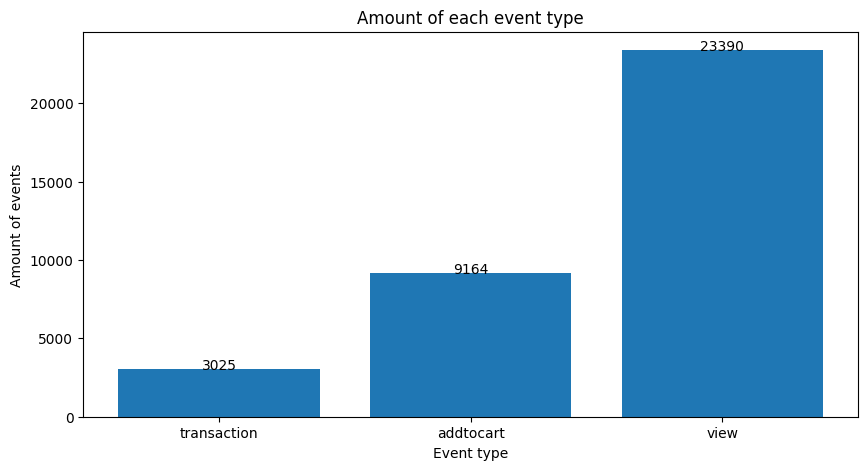

In [106]:
plt.figure(figsize=(10, 5))
plt.bar(event_type_count["event"].to_numpy(), event_type_count["count"].to_numpy())
add_labels(event_type_count["event"].to_numpy(), event_type_count["count"].to_numpy())
plt.title("Amount of each event type")
plt.xlabel("Event type")
plt.ylabel("Amount of events")
plt.show()

### Amount of events per itemid

In [107]:
# count amount of events per itemid
events_per_itemid = (
    train_df
    .select("itemid")
    .group_by("itemid")
    .agg(
        pl.count("itemid")
        .alias("events_count")
    )
    .sort("events_count")
)

print(events_per_itemid)
print(events_per_itemid.select("events_count").describe())

event_counts_distribution = (
    events_per_itemid
    .select("events_count")
    .group_by("events_count")
    .agg(
        pl.count("events_count")
        .alias("itemids_count")
    )
    .sort("events_count")
)

shape: (10_366, 2)
┌────────┬──────────────┐
│ itemid ┆ events_count │
│ ---    ┆ ---          │
│ str    ┆ u32          │
╞════════╪══════════════╡
│ 231590 ┆ 1            │
│ 392194 ┆ 1            │
│ 329467 ┆ 1            │
│ 400188 ┆ 1            │
│ 27701  ┆ 1            │
│ …      ┆ …            │
│ 546    ┆ 78           │
│ 312728 ┆ 85           │
│ 248455 ┆ 99           │
│ 320130 ┆ 164          │
│ 461686 ┆ 204          │
└────────┴──────────────┘
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ events_count │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 10366.0      │
│ null_count ┆ 0.0          │
│ mean       ┆ 3.432279     │
│ std        ┆ 5.086042     │
│ min        ┆ 1.0          │
│ 25%        ┆ 1.0          │
│ 50%        ┆ 2.0          │
│ 75%        ┆ 4.0          │
│ max        ┆ 204.0        │
└────────────┴──────────────┘


[38.98321435462088, 31.87343237507235, 13.698630136986301, 10.55373335905846, 3.9552382789890026, 0.9357514952730079]
100.0


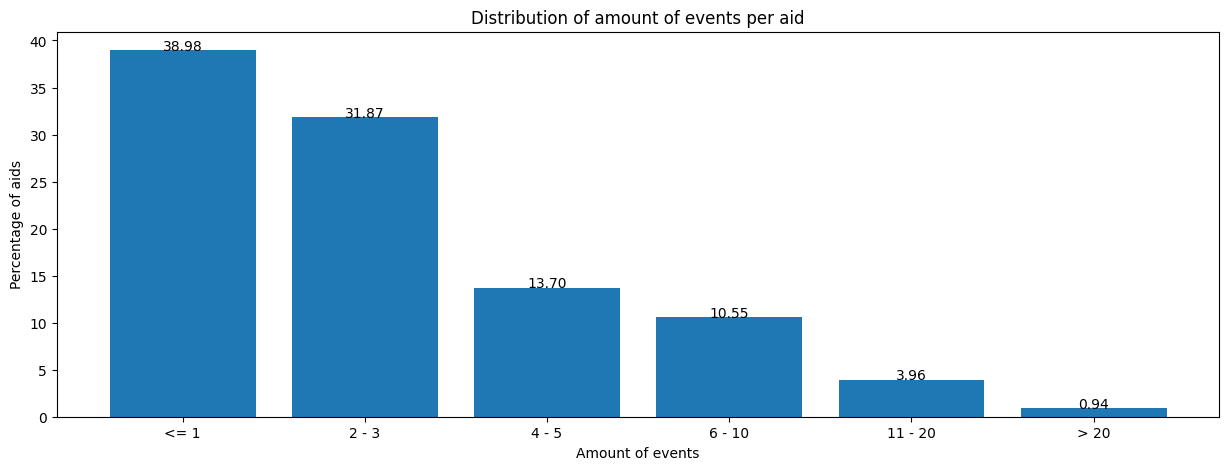

In [108]:
def get_percentage_under_n_events(amount_of_events):
    percentages = []
    labels = []

    total = events_per_itemid.height
    len_events = len(amount_of_events)
    for i in range(len_events):
        if i == 0:
            count = events_per_itemid.filter(pl.col("events_count") <= amount_of_events[i]).height
            percentages.append(count / total * 100)
            labels.append(f"<= {amount_of_events[i]}")
            continue

        n1 = amount_of_events[i-1]
        n2 = amount_of_events[i]

        count = events_per_itemid.filter(pl.col("events_count") > n1, pl.col("events_count") <= n2).height
        percentages.append(count / total * 100)
        labels.append(f"{n1+1} - {n2}")

        if i == len_events-1:
            count = events_per_itemid.filter(pl.col("events_count") > amount_of_events[i]).height
            percentages.append(count / total * 100)
            labels.append(f"> {amount_of_events[i]}")
            continue

    return percentages, labels

amount_of_events = [1, 3, 5, 10, 20]
percentages, labels = get_percentage_under_n_events(amount_of_events)
print(percentages)
print(sum(percentages))

plt.figure(figsize=(15, 5))
plt.bar(labels, percentages)
add_labels(labels, percentages)
plt.title("Distribution of amount of events per itemid")
plt.xlabel("Amount of events")
plt.ylabel("Percentage of itemids")
plt.show()

The distribution of the amount of events per itemid is very skewed. many itemids have very few events, while a few have a lot of events.

itemid

In [170]:
# count amount of views per itemid
views_per_itemid = (
    train_df
    .filter(pl.col("event") == "view")
    .select("itemid")
    .group_by("itemid")
    .agg(
        pl.count("itemid")
        .alias("views_count")
    )
    .sort("views_count")
)

# print(views_per_itemid)
print(views_per_itemid.select("views_count").describe())

# count amount of carts per itemid
carts_per_itemid = (
    train_df
    .filter(pl.col("event") == "addtocart")
    .select("itemid")
    .group_by("itemid")
    .agg(
        pl.count("itemid")
        .alias("carts_count")
    )
    .sort("carts_count")
)

# print(carts_per_itemid)
print(carts_per_itemid.select("carts_count").describe())

# count amount of purchases per itemid
purchases_per_itemid = (
    train_df
    .filter(pl.col("event") == "transaction")
    .select("itemid")
    .group_by("itemid")
    .agg(
        pl.count("itemid")
        .alias("purchases_count")
    )
    .sort("purchases_count")
)

# print(purchases_per_itemid)
print(purchases_per_itemid.select("purchases_count").describe())

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ views_count │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 9640.0      │
│ null_count ┆ 0.0         │
│ mean       ┆ 2.426349    │
│ std        ┆ 3.28647     │
│ min        ┆ 1.0         │
│ 25%        ┆ 1.0         │
│ 50%        ┆ 1.0         │
│ 75%        ┆ 3.0         │
│ max        ┆ 119.0       │
└────────────┴─────────────┘
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ carts_count │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 5490.0      │
│ null_count ┆ 0.0         │
│ mean       ┆ 1.669217    │
│ std        ┆ 1.805303    │
│ min        ┆ 1.0         │
│ 25%        ┆ 1.0         │
│ 50%        ┆ 1.0         │
│ 75%        ┆ 2.0         │
│ max        ┆ 61.0        │
└────────────┴─────────────┘
shape: (9, 2)
┌────────────┬─────────────────┐
│ statistic  ┆ purchases_count │
│ ---        ┆ ---    

Median view count is 1. Top 25 % of items have 3 or more views.
Median cart count is 1. Top 25 % of items have 2 or more carts.
Median order count is 1. Top 25 % of items have 1 or more orders.

itemid

In [113]:
# Count the amount of sessions
sessions_count = train_df.select("session").n_unique()
print("Amount of sessions:", sessions_count)

# Count unique items
items_count = train_df.select("itemid").n_unique()
print("Amount of items:", items_count)

Amount of sessions: 5967
Amount of items: 10366


### Amount of items with views, carts and purchases

In [115]:
itemids_with_views = (
    train_df
    .filter(pl.col("event") == "view")
    .select("itemid")
    .n_unique()
)

itemids_with_carts = (
    train_df
    .filter(pl.col("event") == "addtocart")
    .select("itemid")
    .n_unique()
)

itemids_with_purchases = (
    train_df
    .filter(pl.col("event") == "transaction")
    .select("itemid")
    .n_unique()
)

print(f"Unique itemids: {items_count}")
print(f"Unique itemids with clicks: {itemids_with_views}, {itemids_with_views / items_count * 100:.2f}%")
print(f"Unique itemids with carts: {itemids_with_carts}, {itemids_with_carts / items_count * 100:.2f}%")
print(f"Unique itemids with orders: {itemids_with_purchases}, {itemids_with_purchases / items_count * 100:.2f}%")

Unique aids: 10366
Unique aids with clicks: 9640, 93.00%
Unique aids with carts: 5490, 52.96%
Unique aids with orders: 2261, 21.81%


### Session length in hours

In [147]:
# session length is counted as the last_ts - first_ts
session_length_minutes = (
    train_df
    .with_columns(
        max_ts=pl.col("timestamp").max().over("session"),
        min_ts=pl.col("timestamp").min().over("session"),
    )
    .with_columns(session_length_minutes = (pl.col("max_ts") - pl.col("min_ts")) / 60)
    .select("session", "session_length_minutes")
    .unique()
    .sort("session_length_minutes")
)

print(session_length_minutes)

print(session_length_minutes.select("session_length_minutes").describe())

sessions_under_30_min_percentage = session_length_minutes.filter(pl.col("session_length_minutes") < 15).height / session_length_minutes.height * 100
print(f"Percentage of sessions of under 15 min: {sessions_under_30_min_percentage:.2f}%")

sessions_under_30_min_percentage = session_length_minutes.filter(pl.col("session_length_minutes") < 30).height / session_length_minutes.height * 100
print(f"Percentage of sessions of under 30 min: {sessions_under_30_min_percentage:.2f}%")

sessions_under_hour_percentage = session_length_minutes.filter(pl.col("session_length_minutes") < 60).height / session_length_minutes.height * 100
print(f"Percentage of sessions of under 1 hour: {sessions_under_hour_percentage:.2f}%")

sessions_under_hour_percentage = session_length_minutes.filter(pl.col("session_length_minutes") < 2*60).height / session_length_minutes.height * 100
print(f"Percentage of sessions of under 2 hour: {sessions_under_hour_percentage:.2f}%")

shape: (5_967, 2)
┌─────────┬────────────────────────┐
│ session ┆ session_length_minutes │
│ ---     ┆ ---                    │
│ u32     ┆ f64                    │
╞═════════╪════════════════════════╡
│ 407478  ┆ 0.016667               │
│ 1586520 ┆ 0.016667               │
│ 1089257 ┆ 0.016667               │
│ 197779  ┆ 0.016667               │
│ 577545  ┆ 0.016667               │
│ …       ┆ …                      │
│ 1244930 ┆ 420.133333             │
│ 1439684 ┆ 432.883333             │
│ 663401  ┆ 509.616667             │
│ 1244937 ┆ 511.7                  │
│ 309926  ┆ 589.383333             │
└─────────┴────────────────────────┘
shape: (9, 2)
┌────────────┬────────────────────────┐
│ statistic  ┆ session_length_minutes │
│ ---        ┆ ---                    │
│ str        ┆ f64                    │
╞════════════╪════════════════════════╡
│ count      ┆ 5967.0                 │
│ null_count ┆ 0.0                    │
│ mean       ┆ 15.589688              │
│ std        ┆ 31.9

The vast majority of sessions are relatively short

### Example of a long session

In [156]:
longest_session = (
    session_length_minutes
    .sort("session_length_minutes", descending=True)
    .head(1)
    .select("session")
    .item()
)

longest_session_events = (
    train_df
    .filter(pl.col("session") == longest_session)
    .sort("timestamp")
)

print(longest_session_events)

shape: (125, 6)
┌────────────┬───────────┬───────────┬────────┬───────────────┬─────────┐
│ timestamp  ┆ visitorid ┆ event     ┆ itemid ┆ transactionid ┆ session │
│ ---        ┆ ---       ┆ ---       ┆ ---    ┆ ---           ┆ ---     │
│ u32        ┆ u32       ┆ str       ┆ str    ┆ u32           ┆ u32     │
╞════════════╪═══════════╪═══════════╪════════╪═══════════════╪═════════╡
│ 1439911017 ┆ 247235    ┆ view      ┆ 440937 ┆ null          ┆ 309926  │
│ 1439911286 ┆ 247235    ┆ view      ┆ 182533 ┆ null          ┆ 309926  │
│ 1439911386 ┆ 247235    ┆ view      ┆ 155299 ┆ null          ┆ 309926  │
│ 1439911662 ┆ 247235    ┆ view      ┆ 179005 ┆ null          ┆ 309926  │
│ 1439911675 ┆ 247235    ┆ view      ┆ 95263  ┆ null          ┆ 309926  │
│ …          ┆ …         ┆ …         ┆ …      ┆ …             ┆ …       │
│ 1439945115 ┆ 247235    ┆ view      ┆ 32191  ┆ null          ┆ 309926  │
│ 1439946146 ┆ 247235    ┆ view      ┆ 223366 ┆ null          ┆ 309926  │
│ 1439946185 ┆ 247235 

### Session statistics

In [166]:
time_between_events_in_session = (
    train_df
    .sort(["session", "timestamp"])
    .with_columns(
        next_session = pl.col("session").shift(-1),
        next_timestamp = pl.col("timestamp").shift(-1),
    )
    .with_columns(
        time_between_sec = pl.when(pl.col("session") == pl.col("next_session")).then((pl.col("next_timestamp") - pl.col("timestamp"))).otherwise(None)
    )
    .select("time_between_sec")
    .drop_nulls()
    .sort("time_between_sec", descending=True)
)

print(time_between_events_in_session)
print(time_between_events_in_session.describe())

shape: (29_612, 1)
┌──────────────────┐
│ time_between_sec │
│ ---              │
│ u32              │
╞══════════════════╡
│ 1798             │
│ 1796             │
│ 1794             │
│ 1794             │
│ 1793             │
│ …                │
│ 0                │
│ 0                │
│ 0                │
│ 0                │
│ 0                │
└──────────────────┘
shape: (9, 2)
┌────────────┬──────────────────┐
│ statistic  ┆ time_between_sec │
│ ---        ┆ ---              │
│ str        ┆ f64              │
╞════════════╪══════════════════╡
│ count      ┆ 29612.0          │
│ null_count ┆ 0.0              │
│ mean       ┆ 188.485074       │
│ std        ┆ 289.407684       │
│ min        ┆ 0.0              │
│ 25%        ┆ 28.0             │
│ 50%        ┆ 77.0             │
│ 75%        ┆ 209.0            │
│ max        ┆ 1798.0           │
└────────────┴──────────────────┘


Median time between events is 77 seconds. 75% of events are under 3.48 minutes apart.

### Clicks between carts in sessions

In [243]:
clicks_between_carts = (
    train_df
    .sort(["session", "timestamp"], descending=[False, False])
    .drop(["visitorid", "transactionid"])
    # Remove purchases
    .filter(pl.col("event") != "transaction")
    .with_columns(
        next_itemid = pl.col("itemid").shift(-1),
        next_event = pl.col("event").shift(-1),
        next_session = pl.col("session").shift(-1)
    )
    .filter(pl.col("session") == pl.col("next_session"))
    # Remove items carted multiple times at once
    .filter(pl.when((pl.col("event") == "addtocart") & (pl.col("next_event") == "addtocart") & (pl.col("itemid") == pl.col("next_itemid"))).then(False).otherwise(True))
    .drop(["next_itemid", "next_event", "next_session"])
    # Add index to the dataframe
    .with_row_index()
    # Remove views
    .filter(pl.col("event") == "addtocart")
    # Find delta index between cart or order events
    .with_columns(
        next_index = pl.col("index").shift(-1),
        next_session = pl.col("session").shift(-1)
    )
    .filter(pl.col("session") == pl.col("next_session"))
    .with_columns(
        delta_index=(pl.col("next_index") - pl.col("index")).cast(pl.UInt32)
    )
    .drop(["itemid", "timestamp", "event", "index", "next_index", "next_session"])
    .sort("delta_index", descending=True)
)

print(clicks_between_carts)
print(clicks_between_carts.select("delta_index").describe())

shape: (2_297, 2)
┌─────────┬─────────────┐
│ session ┆ delta_index │
│ ---     ┆ ---         │
│ u32     ┆ u32         │
╞═════════╪═════════════╡
│ 1244937 ┆ 37          │
│ 590913  ┆ 29          │
│ 1439684 ┆ 28          │
│ 1439681 ┆ 27          │
│ 663401  ┆ 26          │
│ …       ┆ …           │
│ 1754411 ┆ 1           │
│ 1754411 ┆ 1           │
│ 1754411 ┆ 1           │
│ 1754411 ┆ 1           │
│ 1760179 ┆ 1           │
└─────────┴─────────────┘
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ delta_index │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 2297.0      │
│ null_count ┆ 0.0         │
│ mean       ┆ 2.972138    │
│ std        ┆ 3.304008    │
│ min        ┆ 1.0         │
│ 25%        ┆ 1.0         │
│ 50%        ┆ 2.0         │
│ 75%        ┆ 3.0         │
│ max        ┆ 37.0        │
└────────────┴─────────────┘


Median time (delta index) between cart events is 2. Mean is 2.97.

### Clicks between orders in sessions

In [284]:
clicks_between_orders = (
    train_df
    .sort(["session", "timestamp"], descending=[False, False])
    .drop(["visitorid", "itemid"])
    # Remove carts
    .filter(pl.col("event") != "addtocart")
    .unique(maintain_order=True)
    .with_row_index()
    .filter(pl.col("event") == "transaction")
    .with_columns(
        next_session = pl.col("session").shift(-1),
        next_index = pl.col("index").shift(-1),
    )
    .filter(pl.col("session") == pl.col("next_session"))
    .with_columns(
        delta_index=(pl.col("next_index") - pl.col("index")).cast(pl.UInt32)
    )
    .drop(["index", "timestamp", "event", "transactionid", "session", "next_session", "next_index"])
)

print(clicks_between_orders)
print(clicks_between_orders.select("delta_index").describe())

shape: (494, 1)
┌─────────────┐
│ delta_index │
│ ---         │
│ u32         │
╞═════════════╡
│ 2           │
│ 12          │
│ 2           │
│ 6           │
│ 6           │
│ …           │
│ 1           │
│ 2           │
│ 1           │
│ 2           │
│ 4           │
└─────────────┘
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ delta_index │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 494.0       │
│ null_count ┆ 0.0         │
│ mean       ┆ 5.601215    │
│ std        ┆ 5.578945    │
│ min        ┆ 1.0         │
│ 25%        ┆ 2.0         │
│ 50%        ┆ 4.0         │
│ 75%        ┆ 7.0         │
│ max        ┆ 40.0        │
└────────────┴─────────────┘


Median time (delta index) between order events is 4. Mean is 5.6.